In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("TrainingSet.csv")

In [3]:
df.head()

,adipose_tissue,adrenal_gland,brain,breast,colon,heart,kidney,leukocyte,liver,lung,...,TSS5k_H1hescH3k27ac,TSS5k_H1hescH3k4me1,TSS5k_H1hescH3k4me3,TSS5k_K562H3k27ac,TSS5k_K562H3k4me1,TSS5k_K562H3k4me3,cancer-miRNA_targets,miRNA_targets,hbm_total_degree,hbm_cancer-protein_degree
0,0.11875,0.285,0.2375,0.11875,0.11875,0.000,0.000,0.0,0.316667,0.095,...,1.40099,0.888889,1.59273,4.98920,4.42028,2.19407,0.0,0.0,113.0,0.0
1,0.00000,0.000,0.0000,0.00000,0.00000,0.475,0.000,0.0,0.000000,0.000,...,29.11400,3.470650,21.45410,3.90171,8.30804,2.64050,0.0,0.0,716.0,0.0
2,0.00000,0.190,0.2375,0.00000,0.11875,0.000,0.000,0.0,0.000000,0.000,...,1.09134,1.245400,4.87542,1.22079,1.39571,1.36042,0.0,0.0,1253.0,1.0
3,0.00000,0.000,0.0000,0.00000,0.00000,0.000,0.000,0.0,0.000000,0.000,...,1.23263,2.263030,1.12352,1.21500,1.18454,1.37733,0.0,0.0,5455.0,15.0
4,0.11875,0.380,0.7125,0.00000,0.11875,0.475,0.285,0.0,0.000000,0.000,...,1.21965,1.817130,1.26316,1.63917,3.15974,1.81917,0.0,0.0,30.0,0.0


In [4]:
y=np.loadtxt("TrainingLabel.txt", dtype = int)

In [5]:
X=np.asarray(df)

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.33,random_state=42)

In [7]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train= scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)  

# It is important to scale tain and val data separately because val is supposed to be unseen data on which we test our models. If we scale them together, data from val set will also be considered while calculating mean, median, IQR, etc

X_train

array([[ 2.        ,  2.33333333,  0.33333333, ...,  0.        ,
        -0.07549187, -0.125     ],
       [ 2.        ,  0.        ,  0.        , ...,  0.        ,
         0.1456373 ,  0.        ],
       [ 2.        ,  6.66666667,  1.66666667, ...,  0.        ,
        -0.06608212,  0.125     ],
       ...,
       [10.        ,  3.33333333,  1.33333333, ...,  0.        ,
        -0.07164243, -0.125     ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.07549187, -0.125     ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         2.25769889,  1.75      ]])

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

svm = SVC(kernel = 'rbf', probability = True)
#svm.fit(X_train,y_train)

C_range = np.logspace(-2, 10 ,13)
gamma_range = np.logspace(-9, 3, num = 13)
param_grid = dict(gamma = gamma_range, C = C_range)
grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
for para, val in best_parameters.items():
    print(para , val)

svm_best = SVC(kernel='rbf', C= best_parameters['C'], gamma = best_parameters['gamma'], probability = True)
svm_best.fit(X_train,y_train)

    
svm_pred=svm_best.predict(X_val)

accsvm=accuracy_score(svm_pred,y_val)*100
rac_svm=roc_auc_score(svm_pred,y_val)
print('Accuracy: {}'.format(accsvm))
print(rac_svm)

C 100000.0
gamma 1e-08
Accuracy: 96.91318327974277
0.8598484848484849


In [9]:
df1=pd.read_csv("ValidSet.csv")

In [10]:
X1=np.asarray(df1)

In [11]:
X_test=scaler.transform(X1)

In [12]:
svm_pred1=svm_best.predict(X_test)

In [13]:
svm_pred1

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
np.unique(svm_pred1,return_counts=True)

(array([0, 1]), array([7240,   13], dtype=int64))

In [16]:
probs=svm_best.predict_proba(X_val)
preds1=probs[:,1]

In [17]:
import sklearn.metrics as metrics
fpr,tpr,threshold=metrics.roc_curve(y_val,preds1)
roc_auc=metrics.auc(fpr,tpr)

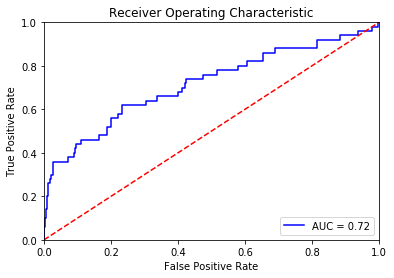

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion matrix, without normalization
[[1504    1]
 [  47    3]]
Normalized confusion matrix
[[9.99e-01 6.64e-04]
 [9.40e-01 6.00e-02]]


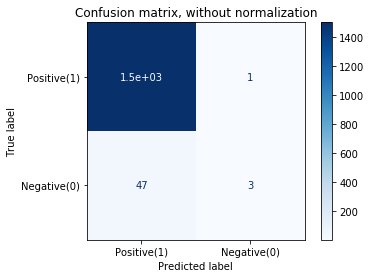

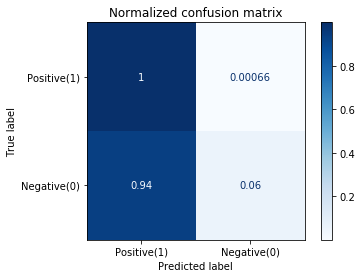

In [19]:
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(precision=2)

class_names=["Positive(1)","Negative(0)"]
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svm_best, X_val, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()